# COMP 551 Mini Project 3
* Yann Bourdé - 260838140
* Marie Ezra Marin - 261053813
* Ethan Kreuzer - 261050944

# Task 1: Acquire, preprocess, and analyze the data.

In [1]:
# Train dataset: 
#   -12500 bad reviews (score less or equal to 4/10)
#   -12500 good reviews (score less or equal to 7/10)

# Test dataset: 
#   -12500 bad reviews (score less or equal to 4/10)
#   -12500 good reviews (score less or equal to 7/10)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from sklearn.model_selection import train_test_split
from collections import defaultdict
import math

from google.colab import drive
drive.mount('/content/drive')

# Please update the path to the csv file according to your own location.
# This path also works for the text files. They must be put in separate test/train folders and pos/neg subfolders.
path = "/content/drive/MyDrive/McGill/COMP 551/Mini3/"

Mounted at /content/drive


In [3]:
# To use the CSV file make which_one = 1.
# To use the 50000 text files make which_one = 0.
which_one = 1

In [4]:
# This package contains a set of typical english words to remove that are not very meaningful. 
# We are using it to narrow down our feature count.
# We also use the tokenizer for white spaces from the package.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Function to create the X and y arrays from the 50000 text files. 
def preprocess(train_test, pos_neg):
  full_path = path + train_test + "/" + pos_neg + "/"
  names = []
  data = []
  for filename in os.listdir(full_path):
    names.append(filename)
    with open(full_path + filename) as fid:
        data.append(fid.readline())
  array = np.array(data)
  N = len(array)
  if pos_neg == "pos":
    labels = np.ones((N))
  elif pos_neg == "neg":
    labels = np.zeros((N))
  return array, labels

In [6]:
# This implementation is for using the CSV file containing the data. 
#
# Get the train and test data.
if which_one == 1:
  big_data = pd.read_csv(path + "IMDB Dataset.csv")
  # Transform positive/negative sentiment labels to 1 and 0.
  big_labels = big_data.loc[:,"sentiment"].to_numpy()
  big_labels = np.where(big_labels == "positive", 1, 0)
  big_data["sentiment"] = big_labels
  # Split test and train data 50/50.
  X_train, X_test, y_train, y_test = train_test_split(big_data['review'].values, big_data['sentiment'].values, test_size=0.5, random_state=42)

In [7]:
# This implementation is for using the 50000 text files containing the data. 
#
# Get the train and test data.
if which_one == 0:
  X_pos, y_pos = preprocess('train', 'pos')
  X_neg, y_neg = preprocess('train', 'neg')
  X_train = np.concatenate((X_pos, X_neg), axis=0)
  y_train = np.concatenate((y_pos, y_neg), axis=0)
  X_pos, y_pos =  preprocess('test', 'pos')
  X_neg, y_neg =  preprocess('test', 'neg')
  X_test = np.concatenate((X_pos, X_neg), axis=0)
  y_test = np.concatenate((y_pos, y_neg), axis=0)

In [8]:
def get_vector(X, feature_number):
  # Use CountVectorizer to get features with frequency.
  vector = CountVectorizer(stop_words=words, token_pattern="[^\W\d_]+", strip_accents='unicode', max_features=feature_number)
  X_t = vector.fit_transform(X, y=None)
  # Get the list of features and return X_train as an array.
  features = vector.get_feature_names_out()
  X_t = X_t.toarray()
  return X_t, features

In [9]:
# Use dictionnary to count the instances of each word for positive or negative reviews.
def get_feature_count(X, y, features):
  # Initiate dict.
  feature_cnt = {}
  for i in range(2):
    feature_cnt[i] = defaultdict(lambda: 0)

  for j in range(X.shape[0]):
    # Positive/negative.
    i = y[j]
    # Add the instance's feature frequencies to the features counts.
    for k in range(len(features)):
      feature_cnt[i][features[k]] += X[j][k]
  return feature_cnt

In [10]:
def evaluate_acc(truth, pred):
  cnt = 0
  for i in range(len(pred)):
    if pred[i] == truth[i]:
      cnt = cnt + 1
  acc = cnt/len(pred)
  return acc

# Task 2: Implement Naive Bayes and BERT models.

## Naive Bayes Implementation.

In [11]:
class NaiveBayes:
    def __init__(self):
      self.pos_count = 0
      self.neg_count = 0
      self.log_pos_prior = 0
      self.log_neg_prior = 0
      pass
    
    def fit(self, X, y):
      N, D = X.shape
      # Count number of positive and negative instances.
      for i in y:
        if i == 1:
           self.pos_count += 1
        elif i == 0:
          self.neg_count += 1
      # Calculate the log_prior for pos/neg.
      self.log_pos_prior =  math.log(self.pos_count / N)
      self.log_neg_prior =  math.log(self.neg_count / N)
      return self

    def predict(self, X, features, feature_count):
      y_pred = []
      for i in X:
        # Set up probabilities for pos/neg.
        pos_prob = self.log_pos_prior
        neg_prob = self.log_neg_prior
        text_words = i.split()
        # Go through each word in the instance and compute the probabilities for pos/neg.
        for j in text_words:
          if j not in features:
            continue
          for l in range(2):
            # Laplace smoothing.
            a = feature_count[l][j] + 1
            # Add prob for pos/neg.
            if l == 1:
              b = self.pos_count + len(features)
              log_prob = math.log(a/b)
              pos_prob += log_prob
            elif l == 0:
              b = self.neg_count + len(features)
              log_prob = math.log(a/b)
              neg_prob += log_prob   
        # Return 1 or 0 based on larger probability between pos/neg.
        if pos_prob >= neg_prob:
          y_pred.append(1)
        elif pos_prob < neg_prob:
          y_pred.append(0)
      return y_pred

## Accuracy using 1000 features.

In [12]:
X_train_vec, features_train = get_vector(X_train, 1000)
feature_count = get_feature_count(X_train_vec, y_train, features_train)

In [13]:
model = NaiveBayes()
model.fit(X_train_vec, y_train)
pred = model.predict(X_test, features_train, feature_count)

In [14]:
acc = evaluate_acc(y_test, pred)
print("Accuracy of prediction on test set : ", acc*100)

Accuracy of prediction on test set :  80.71199999999999


# Other experiments

In [15]:
numbers = [250, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
acc_list = []
for i in numbers:
  v, f = get_vector(X_train, i)
  f_c = get_feature_count(v, y_train, f)
  model = NaiveBayes()
  model.fit(v, y_train)
  p = model.predict(X_test, f, f_c)
  acc = evaluate_acc(y_test, p)*100
  acc_list.append(acc)

In [16]:
print(acc_list)

[73.432, 78.104, 79.644, 80.71199999999999, 82.464, 83.328, 83.524, 83.7, 83.748, 83.916, 84.0, 84.012]


Text(0.5, 1.0, 'Naive Bayes performance with varying number of features')

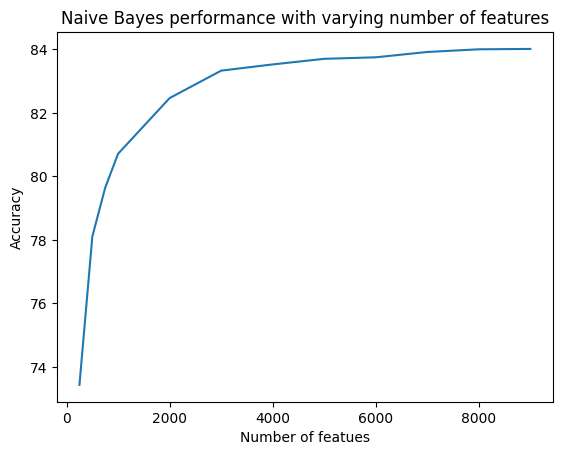

In [17]:
plt.plot(numbers, acc_list)
plt.xlabel("Number of featues")
plt.ylabel("Accuracy")
plt.title("Naive Bayes performance with varying number of features")